 ## Imports and Setup

In [1]:
import os
import sys
import numpy as np
import torch
import random
from tqdm.notebook import tqdm

# Add the src directory to the sys.path
sys.path.append(os.path.abspath('..'))

# Import functions and constants from inference_utils and train_utils
from secret_runway_detection.inference_utils import (
    has_strip_tensors_to_submission_csv,
)

from secret_runway_detection.train_utils import (
    add_buffer_to_label,
)

from secret_runway_detection.model import CombinedModel, SegmentationHead

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


 ## Configuration Parameters

In [2]:
DEBUG = True

ADD_BUFFER = True
BUFFER_TYPE = 'cross'

# Tile and AOI parameters
TILE_SIDE_LEN = 10.0  # in meters
# AOI_HEIGHT = 15270.0  # in meters
# AOI_WIDTH = 15410.0   # in meters

# # ROWS_COUNT = 1527  # Number of tile rows
# # COLUMNS_COUNT = 1541  # Number of tile columns

# assert (TILE_SIDE_LEN == AOI_HEIGHT / ROWS_COUNT) and (TILE_SIDE_LEN == AOI_WIDTH / COLUMNS_COUNT)

# Model input and output dimensions
INPUT_IMAGE_SIDE_LEN_PX = 224  # in pixels
TILES_PER_INPUT_AREA_LEN = 224  # Number of tiles per side in one input area

# Number of input areas to cover the AOI
INPUT_AREAS_VERTICALLY = 10
INPUT_AREAS_HORIZONTALLY = 10

# Threshold for converting model outputs to binary predictions
THRESHOLD = 0.5  # Adjust based on validation performance

# Path to the trained model checkpoint
MODEL_CHECKPOINT_PATH = '../checkpoints/trained_model.pth'  # Update this path

# Path to save the submission CSVs
SUBMISSION_CSV_DIR = 'submission_csvs'
os.makedirs(SUBMISSION_CSV_DIR, exist_ok=True)


 ## Load the Trained Model

In [3]:
# Load model checkpoint from ../checkpoints dir
import timm


backbone = model = timm.create_model(
        'swin_base_patch4_window7_224',
        pretrained=False,
        num_classes=0,  # Assuming binary classification
    )

segmentation_head = SegmentationHead()

model = CombinedModel(backbone, segmentation_head)

model.load_state_dict(torch.load(MODEL_CHECKPOINT_PATH, map_location=device))

model.eval()
torch.no_grad()

model

/tmp/ipykernel_67627/2874891720.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_CHECKPOINT_PATH, map_location=device))


CombinedModel(
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=51

 ## Run Inference on Each AOI

In [8]:
has_strip_maps = {}
for aoi_name, confidence_map in aoi_confidence_maps.items():
    has_strip_map = confidence_map > THRESHOLD
    if ADD_BUFFER:
        has_strip_map = add_buffer_to_label(has_strip_map, num_buffer_tiles=20, buffer_type=BUFFER_TYPE)
    has_strip_maps[aoi_name] = has_strip_map

## Visualize one AOI confidence map and the corresponding image

Overlaying confidence map...


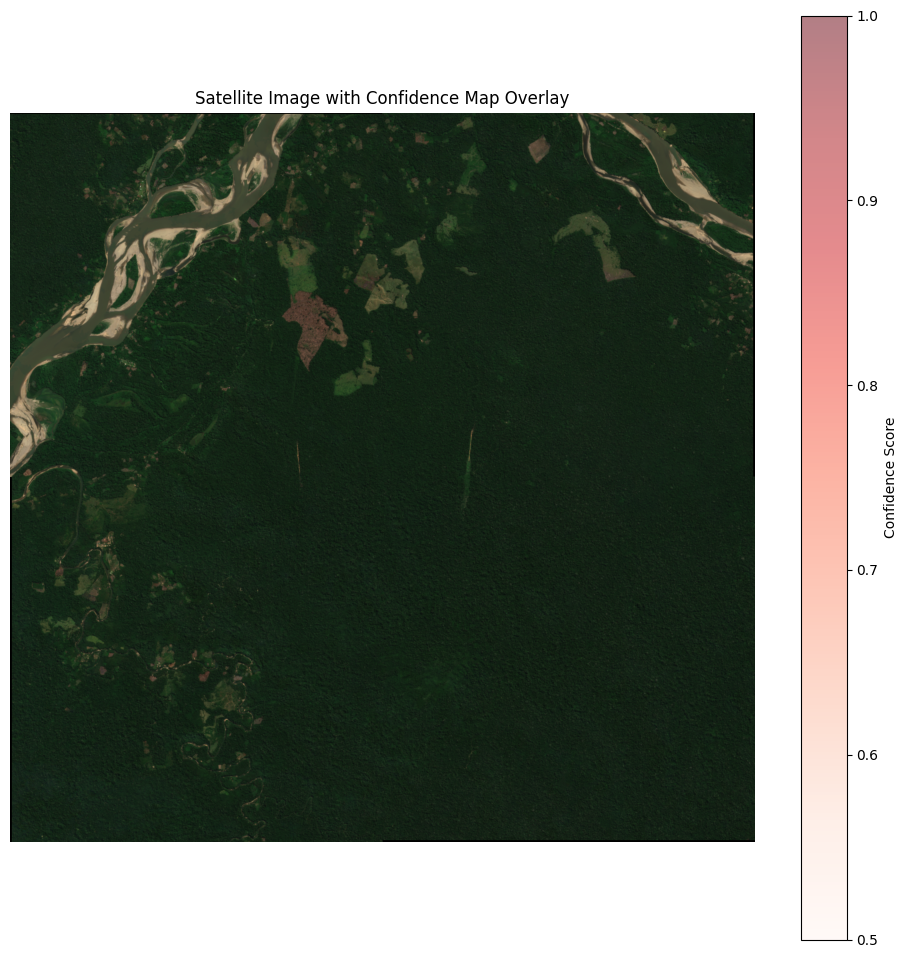

Confidence map plot displayed.
Overlaying has-strip map...


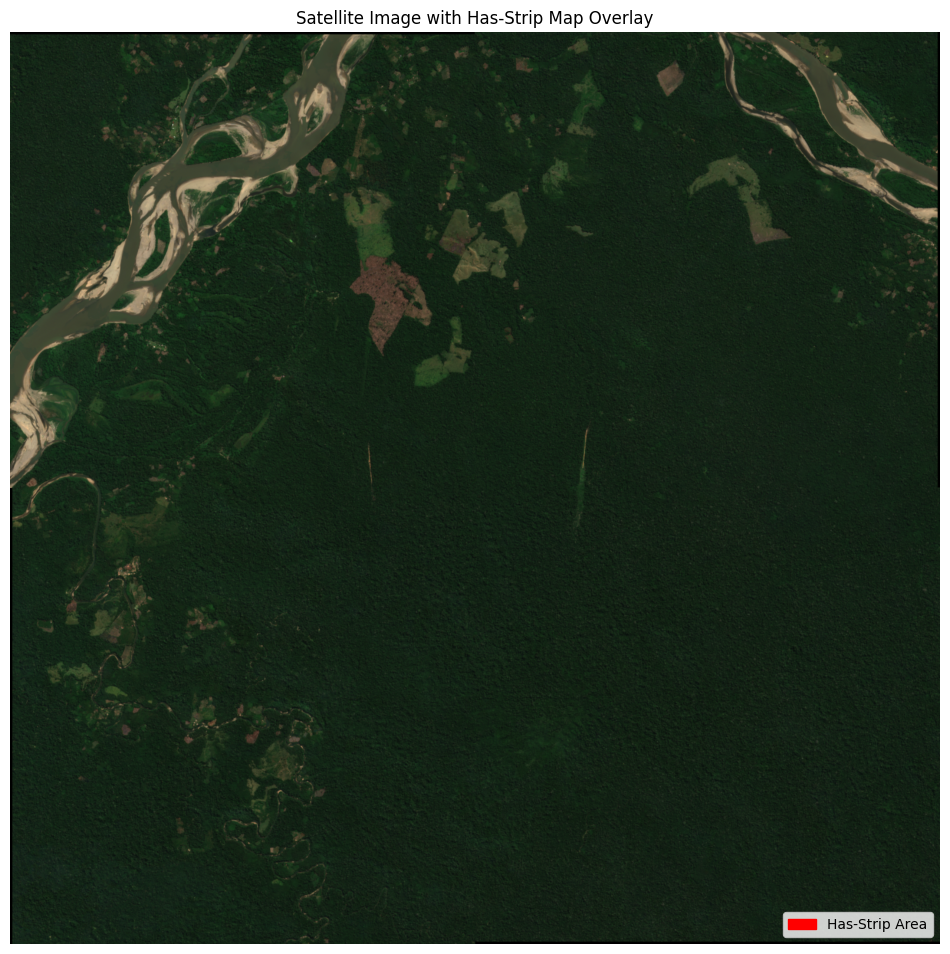

Has-strip map plot displayed.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from skimage.transform import resize
import matplotlib.colors as mcolors
import torch

# Function to normalize and prepare the satellite image for display
def prepare_satellite_image(image_data):
    # Stack bands into RGB format
    img_rgb = np.dstack((image_data[0], image_data[1], image_data[2]))
    # Normalize the image for display
    img_rgb = img_rgb.astype(float)
    img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())
    return img_rgb

# Function to overlay the confidence map on the satellite image
def overlay_confidence_map(satellite_image, confidence_map):
    print("Overlaying confidence map...")
    # Convert confidence_map to NumPy array if it's a PyTorch tensor
    if isinstance(confidence_map, torch.Tensor):
        confidence_map = confidence_map.detach().cpu().numpy()
    
    plt.figure(figsize=(12, 12))
    plt.imshow(satellite_image)
    plt.title("Satellite Image with Confidence Map Overlay")
    plt.axis('off')
    
    # Resize the confidence map to match the satellite image dimensions
    confidence_map_resized = resize(confidence_map, (satellite_image.shape[0], satellite_image.shape[1]),
                                    order=1, preserve_range=True, anti_aliasing=False)
    
    # Create a color map for the confidence map
    cmap = plt.cm.Reds
    cmap.set_under(color='none')  # Make values below the threshold transparent
    
    # Define a threshold for visualization
    THRESHOLD = 0.5  # Adjust based on your data
    
    # Overlay the confidence map
    plt.imshow(confidence_map_resized, cmap=cmap, alpha=0.5, vmin=THRESHOLD, vmax=1)
    
    # Add a colorbar
    plt.colorbar(label='Confidence Score')
    
    plt.show()
    print("Confidence map plot displayed.")

# Function to overlay the has-strip map on the satellite image
def overlay_has_strip_map(satellite_image, has_strip_map):
    print("Overlaying has-strip map...")
    # Convert has_strip_map to NumPy array if it's a PyTorch tensor
    if isinstance(has_strip_map, torch.Tensor):
        has_strip_map = has_strip_map.detach().cpu().numpy()
    
    plt.figure(figsize=(12, 12))
    plt.imshow(satellite_image)
    plt.title("Satellite Image with Has-Strip Map Overlay")
    plt.axis('off')
    
    # Resize the has-strip map to match the satellite image dimensions
    has_strip_map_resized = resize(has_strip_map.astype(float), (satellite_image.shape[0], satellite_image.shape[1]),
                                   order=0, preserve_range=True, anti_aliasing=False)
    
    # Create a colormap for the has-strip map
    cmap = mcolors.ListedColormap(['none', 'red'])
    bounds = [0, 0.5, 1]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    # Overlay the has-strip map
    plt.imshow(has_strip_map_resized, cmap=cmap, norm=norm, alpha=0.5)
    
    # Add a legend
    legend_elements = [
        Patch(facecolor='red', edgecolor='red', label='Has-Strip Area')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.show()
    print("Has-strip map plot displayed.")

# Example usage
# Assuming you have 'aoi_image', 'confidence_map', and 'has_strip_map' variables
satellite_image = prepare_satellite_image(aoi_image)
overlay_confidence_map(satellite_image, confidence_map)
overlay_has_strip_map(satellite_image, has_strip_map)


 ## Notes

In [10]:
# %%
# - Ensure that the coordinate reference systems (CRS) are consistent throughout the process.
# - Verify the indexing of rows and columns in the `tensor_to_submission_csv` function to match the competition requirements.
# - The code assumes that the helper functions are correctly defined in `inference_utils.py` and `train_utils.py`.
# - Adjust paths and constants as necessary based on your project structure.


 ## Conclusion

In [11]:
# %%
print("Inference process completed for all AOIs. Submission files are ready.")



Inference process completed for all AOIs. Submission files are ready.
